Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh | bash
# This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
# from the toolbar then `Change runtime type`. You can then delete this cell.

Install needed packages

In [ ]:
using Pkg; Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])

using DataFrames
using Plots
using CategoricalArrays
using Random
using MLJBase: machine, transform
using TableTransforms
using Imbalance
using HTTP: download

### 1. Generate Random Data

In [2]:
rng = Random.default_rng()

type = "ColTable"
num_rows = 300
num_features = 2
means = [0.1 0.3 0.5]
stds = [0.1 0.1 0.1]
class_probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(
	num_rows,
	num_features;
	min_sep = 0.1,
	stds,
	class_probs,
	type,
	insert_y = y_ind,
	rng = 42,
)
X, y = generate_imbalanced_data(
	num_rows,
	num_features;
	min_sep = 0.1,
	stds,
	class_probs,
	type,
	rng = 42,
)

((Column1 = [0.642, 0.722, 0.576, 0.613, 0.458, 0.786, 0.659, 0.275, 0.371, 0.709  …  0.449, 0.817, 0.551, 0.697, 0.44, 0.483, 0.304, 0.738, 0.747, 0.495], Column2 = [0.614, 0.529, 0.483, 0.654, 0.652, 0.373, 0.449, 0.701, 0.667, 0.617  …  0.322, 0.384, 0.691, 0.56, 0.595, 0.74, 0.597, 0.442, 0.441, 0.384]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 1, 0, 0, 2, 2, 0  …  0, 0, 1, 0, 2, 1, 2, 0, 0, 0])

### 2. Apply ENN Undersampler

#### Using Imbalance Only

In [3]:
@warn "asdasd"

┌ Warning: asdasd
└ @ Main /Users/essam/Documents/GitHub/Imbalance.jl/examples/undersample_enn.ipynb:1


In [4]:
X_under, y_under = enn_undersample(X, y; keep_condition="all", min_ratios = 0.01, rng = 42)
checkbalance(y_under)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00



Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  class:  2


1: ▇▇▇▇▇▇▇▇▇▇▇▇ 28 (25.0%) 
2: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 40 (35.7%) 
0: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 112 (100.0%) 


#### Using MLJ

In [5]:
naive_model = Imbalance.MLJ.ENNUndersampler(
	k = 4,
	keep_condition = "all",
	min_ratios = Dict(0 => 1.0, 1 => 1.0, 2 => 0.9),
	rng = 42,
)
mach = machine(naive_model)
X_under, y_under = transform(mach, X, y)


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00


((Column1 = [0.642, 0.722, 0.576, 0.786, 0.659, 0.709, 0.735, 0.558, 0.755, 0.594  …  0.382, 0.329, 0.413, 0.369, 0.392, 0.319, 0.327, 0.287, 0.246, 0.304], Column2 = [0.614, 0.529, 0.483, 0.373, 0.449, 0.617, 0.601, 0.374, 0.546, 0.446  …  0.479, 0.452, 0.464, 0.512, 0.567, 0.578, 0.604, 0.644, 0.634, 0.597]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Using TableTransforms

In [6]:
using Imbalance: TableTransforms.ENNUndersampler
naive_model_t = ENNUndersampler(y_ind, min_ratios=Dict(0=>1.0, 1=> 0.9, 2=>1.0), rng=42)
Xyover = Xy |> naive_model_t

(Column1 = [0.642, 0.722, 0.576, 0.613, 0.786, 0.659, 0.709, 0.735, 0.558, 0.755  …  0.414, 0.369, 0.392, 0.319, 0.327, 0.287, 0.246, 0.3, 0.44, 0.304],
 Column2 = [0.614, 0.529, 0.483, 0.654, 0.373, 0.449, 0.617, 0.601, 0.374, 0.546  …  0.345, 0.512, 0.567, 0.578, 0.604, 0.644, 0.634, 0.65, 0.595, 0.597],
 Column3 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],)

### 3. Plot the Results

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


    Updating `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  [c709b415] ~ Imbalance v0.1.0 `..` ⇒ v0.1.1 `..`
    Updating `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


  [c709b415] ~ Imbalance v0.1.0 `..` ⇒ v0.1.1 `..`


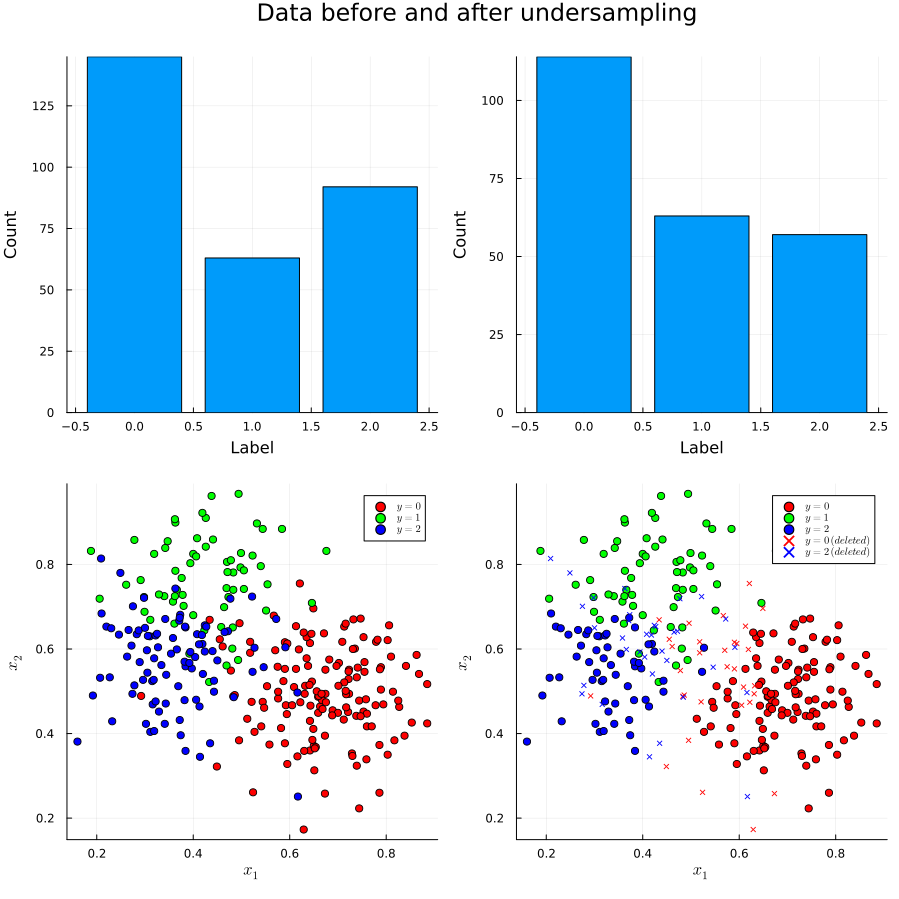

In [7]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, y_under, X, X_under)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/enn_undersample.gif")
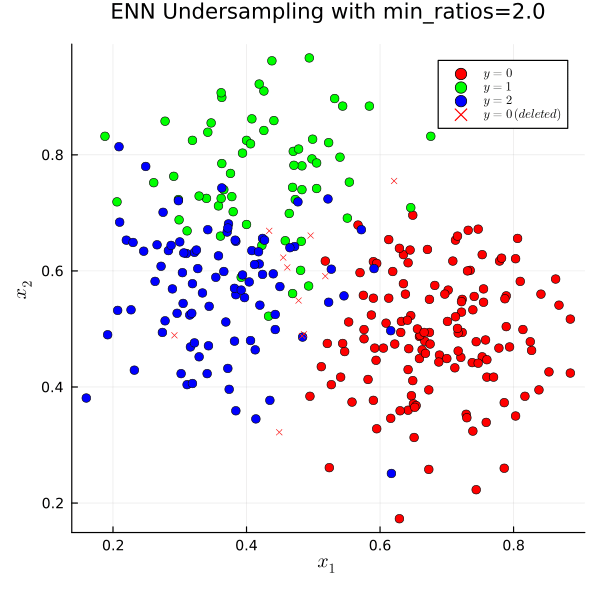

In [8]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for min_ratios ∈ 2.0:-0.05:0.1
	X_under, y_under = enn_undersample(X, y; min_ratios = min_ratios, rng = 42)
	plot_data(y, y_under, X, X_under; single_plot=true,  
			  single_plot_title="ENN Undersampling with min_ratios=$min_ratios")
end
gif(anim, (isdir("./assets")) ? "./assets/enn_undersample.gif" : "./enn_undersample.gif", fps=3)